# Introduction

In [1]:
from uarray import *

## Creating Arrays

Everything (Operations and Symbols) are one of two types:

* Arrays: Reduce down to Array(length: Accessor, content: Accessor)
* Accessors: Accessors support calling Get(index: Accessor, content: Accessor) -> Array

### Scalar

We can add custom values as scalars:

In [2]:
a_scalar = scalar(123)
print(a_scalar)
a_scalar

Array(NoLengthAccessor(), 123)


Array(NoLengthAccessor(), ScalarAccessor('123'))

We see that it's an Array with a length of `NoLengthAccessor()` and a content of `ScalarAccessor(123)`.

Now we can take the shape of a scalar:

In [3]:
a_scalar_shape = Shape(a_scalar)
a_scalar_shape

Shape(Array(NoLengthAccessor(), ScalarAccessor('123')))

We see that the shape is not computed.

It just contains a reference to the arrays it operates on:

In [4]:
a_scalar_shape.operands

[Array(NoLengthAccessor(), ScalarAccessor('123'))]

It also has a shorter representation we can print based on the Mathematics of Arrays symbols:

In [5]:
print(a_scalar_shape)

ρ(Array(NoLengthAccessor(), 123))


We call `replace` to keep replacing expressions until no more are matched:

In [6]:
replace_debug(a_scalar_shape, False)

ρ(Array(NoLengthAccessor(), 123))

  Shape(Array(NoLengthAccessor(), ScalarAccessor('123')))
->ShapeInner(ScalarAccessor('()'), Array(NoLengthAccessor(), ScalarAccessor('123')))

ShapeInner((), Array(NoLengthAccessor(), 123))

  ShapeInner(ScalarAccessor('()'), Array(NoLengthAccessor(), ScalarAccessor('123')))
->Array(ScalarAccessor('0'), VectorAccessor())

Array(0, <>)


Array(ScalarAccessor('0'), VectorAccessor())

### Vector

We see that the shape of a scalar is `VectorAccessor`. We can create arrays with vector accessors with the `vector` helper functions.

In [7]:
??vector

Signature: vector(*values)
Docstring: <no docstring>
Source:   
def vector(*values):
    return vector_of(*(ScalarAccessor(v) for v in values))
File:      ~/p/uarray/uarray/uarray.py
Type:      function


In [8]:
a_vector = vector(1, 2, 3)
print(a_vector)
a_vector

Array(3, <1 2 3>)


Array(ScalarAccessor('3'), VectorAccessor(ScalarAccessor('1'), ScalarAccessor('2'), ScalarAccessor('3')))

We can see the shape of a vector:

In [9]:
a_vector_shape = replace(Shape(a_vector))
print(a_vector_shape)

Array(1, <3>)


Which is itself a vector. 

### Iota

Now let's do something more interesting and create a range of values:

In [10]:
a_range = Iota(scalar(10))
print(a_range)

ι(Array(NoLengthAccessor(), 10))


In [11]:
print(replace(Shape(a_range)))

Array(1, <10>)


This is a vector of length 10. Let's see that the 5th element is the integer 5.

In [12]:
print(replace(Index(vector(5), a_range)))

Array(NoLengthAccessor(), 5)


Here we use a new command `Index` which takes in a vector of indices and the an array and returns a subarray.

Let's try adding taking it's sum:

In [13]:
replace(ReduceVector(scalar(0), ScalarAccessor(Add), a_range))

Array(NoLengthAccessor(), ScalarAccessor('45'))

In [14]:
sum(range(10))

45

Nowe we have an example taking the outer product of two iotas and indexing them

In [15]:
replaced = replace(OuterProduct(Iota(scalar(4)), ScalarAccessor(Multiply), Iota(scalar(4))))
pprint.pprint(replaced)

Array(ScalarAccessor('4'),
      GetBySubstituting(ScalarAccessor("'idx_5'"),
                        Array(ScalarAccessor('4'),
                              GetBySubstituting(ScalarAccessor("'idx_6'"),
                                                Array(NoLengthAccessor(),
                                                      MultiplyAccessor(UnboundAccessor('', variable_name=idx_5),
                                                                       UnboundAccessor('', variable_name=idx_6)))))))


In [16]:
pprint.pprint(replace(Index(vector(2, 3), replaced)))

Array(NoLengthAccessor(), ScalarAccessor('6'))


In [36]:
replace(BinaryOperation(Iota(scalar(10)), ScalarAccessor(Multiply), scalar(5)))

Array(ScalarAccessor('10'), GetBySubstituting(ScalarAccessor("'idx_27'"), Array(NoLengthAccessor(), MultiplyAccessor(UnboundAccessor('', variable_name=idx_27), ScalarAccessor('5')))))

## Abstract Variables

Let's look at how abstract variables are implemented.


### 0D
We can make one that is an anstract 0D scalar:

In [17]:
Z = AbstractWithDimension(0, "Z")
print(Z)
replaced_Z = replace(Z)
pprint.pprint(replaced_Z)

Z^0
Array(NoLengthAccessor(), UnboundAccessor('', variable_name=Z_content))


We see that the content of this is given the name `Z_content`. We can then replace that later with the actual value, after it has been simplified:

In [18]:
replace(matchpy.substitute(replaced_Z, {"Z_content": ScalarAccessor(10)}))

Array(NoLengthAccessor(), ScalarAccessor('10'))

### 1D

This is all fine and good, but what about an array with more dimensions, like a 1D array?

In [19]:
A = AbstractWithDimension(1, "A")
print(A)
replaced_A = replace(A)
pprint.pprint(replaced_A)

A^1
Array(Content(Get(ScalarAccessor('0'),
                  UnboundAccessor('', variable_name=A_shape))),
      ForwardGetAccessor(Array(NoLengthAccessor(),
                               UnboundAccessor('', variable_name=A_content))))


We can get the shape of this:

In [20]:
replaced_shape_a = replace(Shape(replaced_A))
print(replaced_shape_a)

Array(1, <Content(Get(0, UnboundAccessor(A_shape)))>)


It's a bit weird, but it makes sense if you squint. The `A_shape` is an accesor that returns the shape. So the shape is an array of length 1 where the first element is a scalar that is getting the first element from the shape. Yes it's not that intuitive and we could write some special case rewrite rules to clean this up (like if a vecto contains just a bunch of get values of another accessor, just replace it with that), but it works!

In [21]:
actual_shape_accesor = VectorAccessor(ScalarAccessor(10))
print(replace(matchpy.substitute(replaced_shape_a, {"A_shape": actual_shape_accesor})))

Array(1, <10>)


Now let's get an item from this:

In [22]:
replaced_get_A = replace(Get(ScalarAccessor(10), Content(A)))
print(replaced_get_A)

Array(NoLengthAccessor(), Content(Get(10, UnboundAccessor(A_content))))


### 2D

Now let's make a matrix


In [23]:
B = AbstractWithDimension(2, "B")


In [24]:
pprint.pprint(replace(B))

Array(Content(Get(ScalarAccessor('0'),
                  UnboundAccessor('', variable_name=B_shape))),
      GetBySubstituting(ScalarAccessor("'idx_9'"),
                        Array(Content(Get(ScalarAccessor('1'),
                                          UnboundAccessor('', variable_name=B_shape))),
                              ForwardGetAccessor(Array(NoLengthAccessor(),
                                                       Content(Get(UnboundAccessor('', variable_name=idx_9),
                                                                   UnboundAccessor('', variable_name=B_content))))))))


In [25]:
pprint.pprint(replace(Get(UnboundAccessor("j"), Content(Get(UnboundAccessor("i"), Content(replace(B)))))))

Array(NoLengthAccessor(),
      Content(Get(UnboundAccessor('', variable_name=j),
                  Content(Get(UnboundAccessor('', variable_name=i),
                              UnboundAccessor('', variable_name=B_content))))))


In [26]:
# A_value = Iota(scalar(10))
# A_subs = matchpy.substitute(replaced_A, {"A_content": Content(A_value), "A_shape": Shape(A_value)})
# pprint.pprint(replace(A_subs))

# Paper Example

Now let's look at the example from the paper in `uarray-docs`.

In [27]:
A = AbstractWithDimension(3, "A")
B = AbstractWithDimension(3, "B")
r = InnerProduct(
    Index(vector(1, 0), A),
    ScalarAccessor(Add),
    ScalarAccessor(Multiply),
    Index(
        vector(2),
        OuterProduct(
            Index(vector(1, 0), A),
            ScalarAccessor(Multiply),
            Index(vector(0, 1), B)
        )
    )
)
print(r)

((Array(2, <1 0>) ψ A^3) +·* (Array(1, <2>) ψ ((Array(2, <1 0>) ψ A^3) ·* (Array(2, <0 1>) ψ B^3))))


In [28]:
replaced_r = replace(r)
pprint.pprint(replaced_r)

BinaryOperation(Array(NoLengthAccessor(),
                      Content(Get(ScalarAccessor('2'),
                                  Content(Get(ScalarAccessor('0'),
                                              Content(Get(ScalarAccessor('1'),
                                                          UnboundAccessor('', variable_name=A_content)))))))),
                ScalarAccessor("Multiply['*', Arity(min_count=2, fixed_size=True), infix]"),
                InnerProduct(Array(Content(Get(ScalarAccessor('2'),
                                               UnboundAccessor('', variable_name=A_shape))),
                                   ForwardGetAccessor(Array(NoLengthAccessor(),
                                                            Content(Get(ScalarAccessor('0'),
                                                                        Content(Get(ScalarAccessor('1'),
                                                                                    UnboundAccessor('', variable_n

This is a bit opaque, but does represent the right optimized form. Let's now conver this to a string of NumPy code:

In [29]:
import numpy as np

In [30]:
A = np.arange(30).reshape((2, 3, 5))
B = 2 + A

In [31]:
res = replace(Content(matchpy.substitute(replaced_r, {"A_content": NumpyAccessor("A"), "B_content": NumpyAccessor("B")})))
pprint.pprint(res)

NumpyAccessor(('A[1, 0, 2] * np.inner(A[1, 0, :], B[0, 1, :])', ()))


In [32]:
eval(res.code)

13175

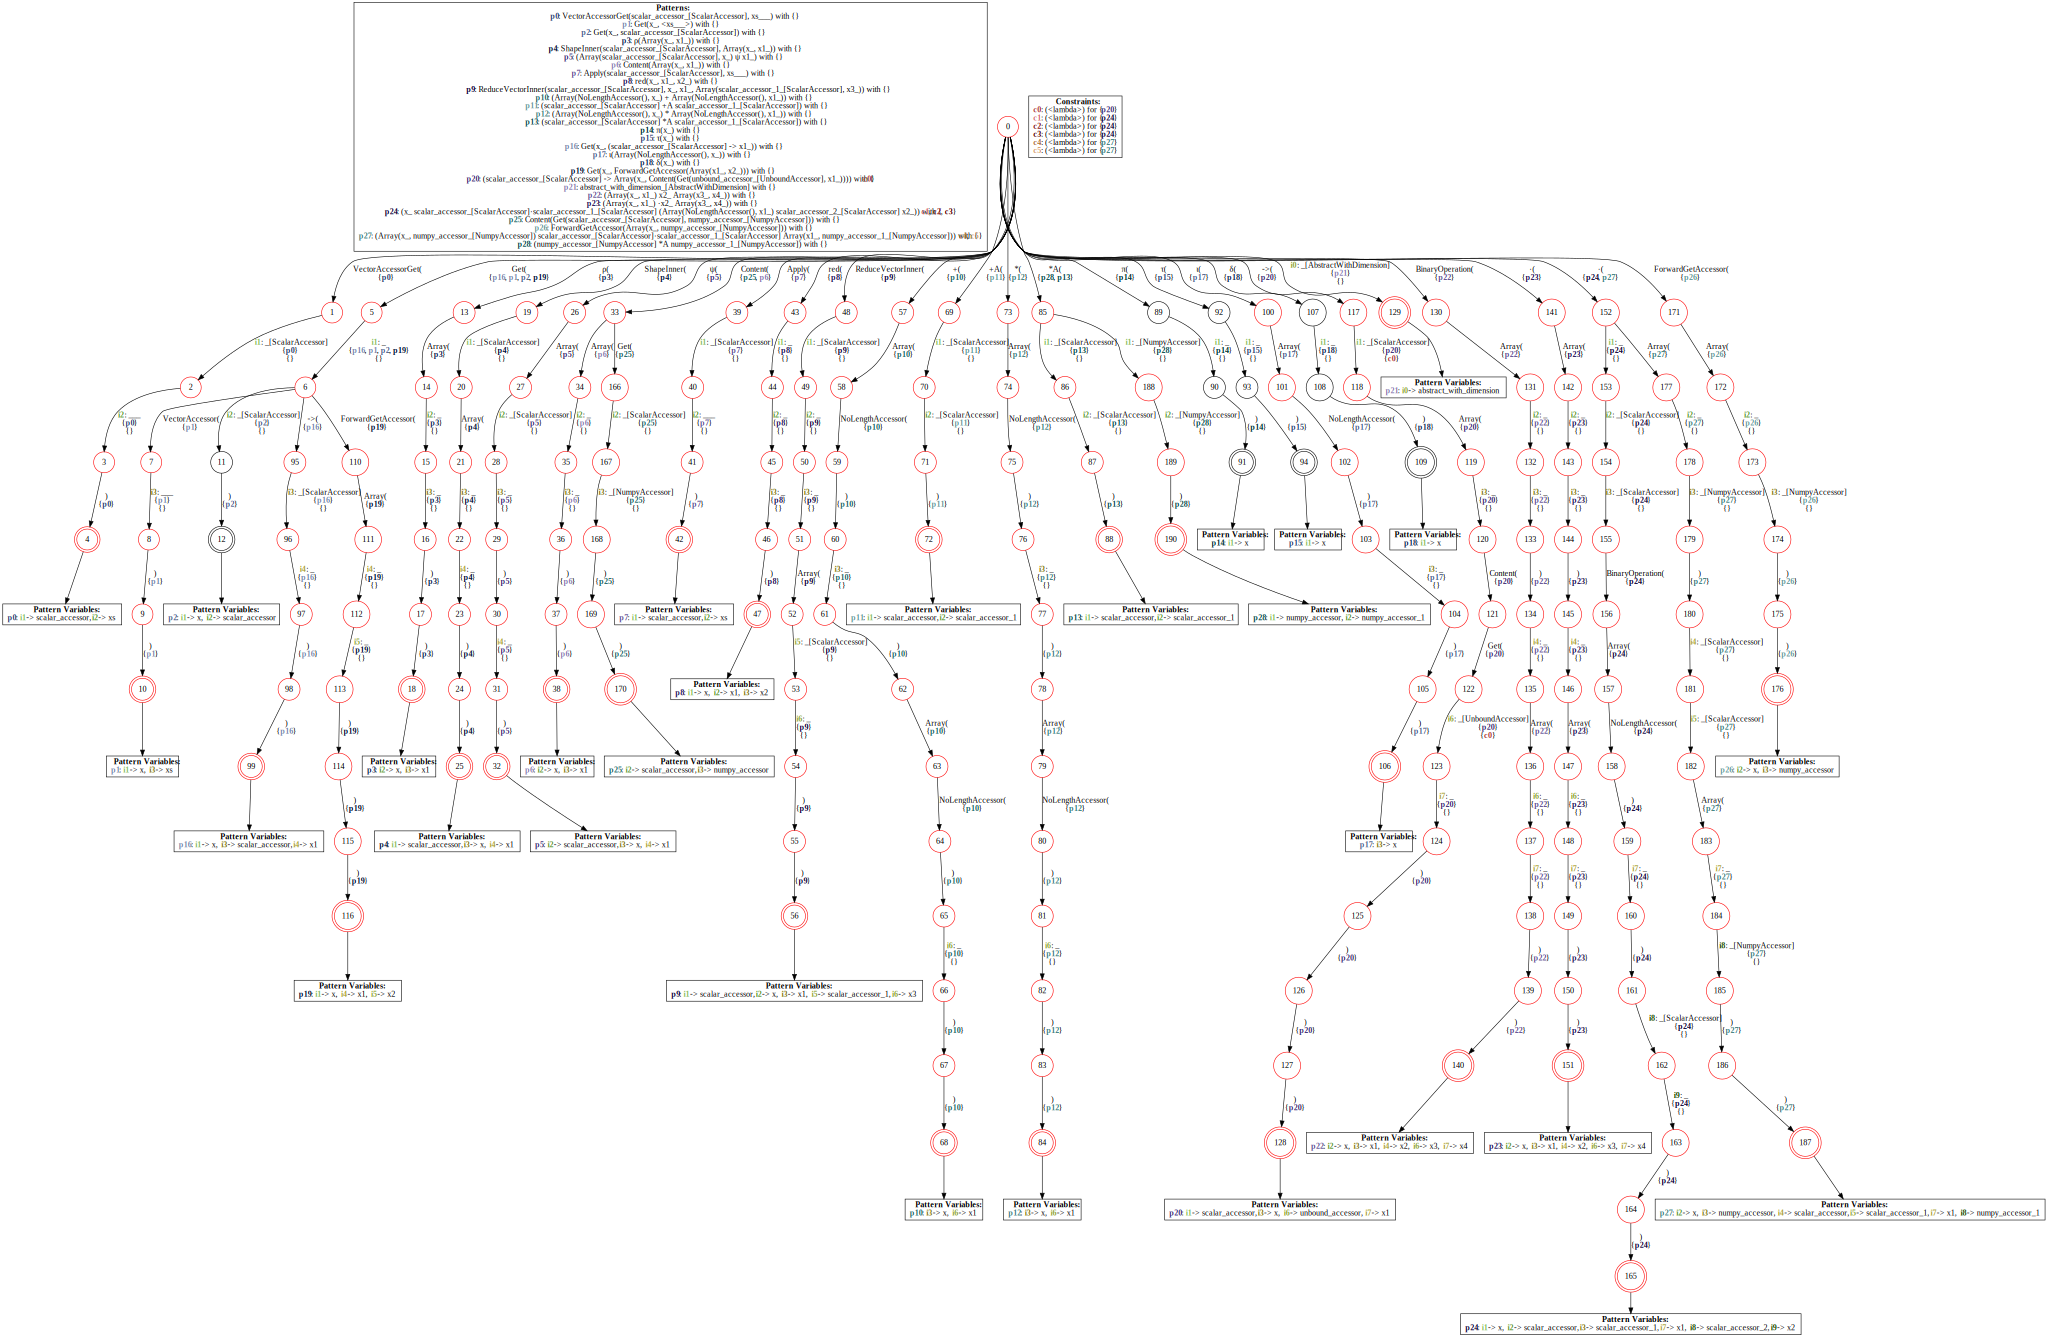

In [33]:
replacer.matcher.as_graph()